[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Please insert the risk-free rate you would like to use (e.g., 0.04 for 4%):  0.02


The following weights were allocated to each stock (in decimals):
AMZN:  0.3174
MSFT:  0.4000
GOOG:  0.0000
LIN:  0.2826
SPY:  0.0000


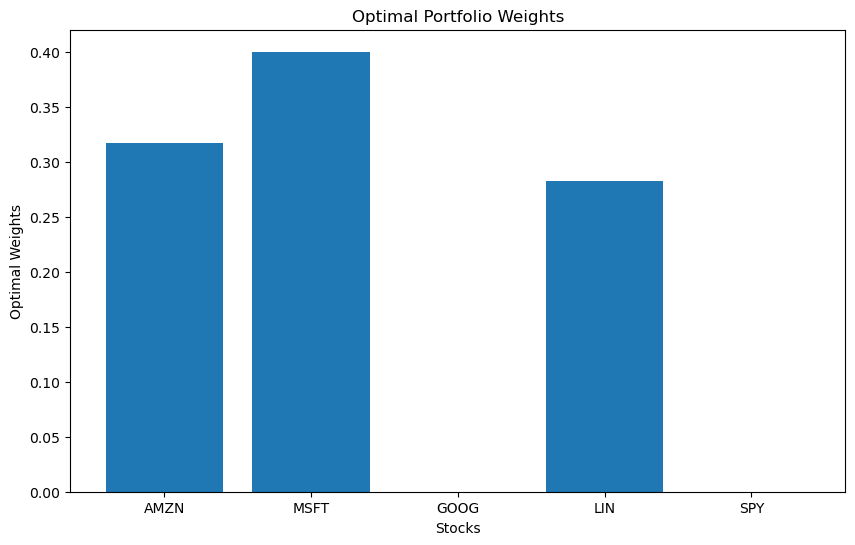

The Expected Annual Return of the Risky Asset is: 0.2166
The Expected Volatility of the Risky Asset is: 0.2166
The Optimal Sharpe Ratio of the Risky Asset is: 0.8556
Given your degree of risk aversion, the optimal percentage of your wealth allocated in the Risky Asset is: 53.19 %
Consequently, the optimal percentage of your wealth allocated in the Risk-Free Asset is: 46.81 %
Thank you very much for using our program.


In [62]:
# This program was written in Python programming language
# Disclaimer: This is no investment advice
# ChatGPT was used to correct and improve the program

# Step 2: Risk/Return optimization of the Risky Asset (portfolio of stocks)
# Source: O’Connell, R. (2023). Portfolio Optimization in Python: Boost Your Financial Performance. Youtube

# Import necessary libraries
import yfinance as yf  # For downloading financial data from Yahoo Finance
import pandas as pd  # For data manipulation and analysis
from datetime import datetime  # For handling date and time
from dateutil.relativedelta import relativedelta  # For manipulating dates with respect to different time intervals
import numpy as np  # For numerical operations
from scipy.optimize import minimize  # For optimization tasks

# Define the stocks that are of interest
stocks = ["AMZN", "MSFT", "GOOG", "LIN", "SPY"]
end_date = datetime.today()  # Set the end date for the data to today
start_date = end_date - relativedelta(years=10)  # Set the start date for the data to 10 years ago from today

# Initialize an empty DataFrame to store the adjusted close prices of the stocks
adj_close_df = pd.DataFrame()
# Loop through each stock symbol to download its data
for stock in stocks:
    try:
        # Download stock data from Yahoo Finance from start_date to end_date
        data = yf.download(stock, start=start_date, end=end_date)
        # Extract the 'Adjusted Close' prices and add them to the DataFrame
        adj_close_df[stock] = data["Adj Close"]
    except Exception as e:
        # If there's an error during download, print the error
        print(f"Error downloading {stock}: {e}")
        
# Input loop to capture and validate the user-provided risk-free rate
while True:
    try:
        # Request input from the user for the risk-free rate in decimal form
        risk_free_rate = float(input("Please insert the risk-free rate you would like to use (e.g., 0.04 for 4%): "))
        # Validate if the input rate is within the logical range (-1, 1) -> risk-free rate might be negative
        if not -1 < risk_free_rate < 1:
            print("Please enter a rate between -1 and 1.")
            continue  # Restart the loop if input is not valid
        break  # Break the loop if the input is valid
    except ValueError:
        # Handle the case where input cannot be converted to float
        print("Invalid input. Please enter a valid risk-free rate in decimal form (e.g., 0.04).")

# Calculate log returns of the stocks
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()  # Divide one day's stock price by the previous day's stock price, drop NA values

# Calculate the covariance matrix of the log returns to understand how stocks move together
cov_matrix = log_returns.cov() * 252  # Annualize the covariance by multiplying by the number of trading days

# Define a function to calculate the standard deviation of portfolio returns, which is a measure of risk
def standard_deviation(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# Define a function to calculate the expected return of the portfolio
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252  # Annualize by multiplying by the number of trading days

# Define a function to calculate the Sharpe ratio, which measures the performance of an investment compared to a risk-free asset
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# Define the objective function to be minimized (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Constraints to ensure that the sum of portfolio weights is 1
constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
# Set bounds for the weights of each stock in the portfolio (no short selling, max 40% allocation to any stock)
bounds = [(0, 0.4) for _ in range(len(stocks))]
# Initial guess for the weights
initial_weights = np.array([1/len(stocks)] * len(stocks))

# Perform the optimization to maximize the Sharpe Ratio (minimize the negative Sharpe Ratio)
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                             method="SLSQP", constraints=constraints, bounds=bounds)

# Retrieve the optimal weights from the optimization results
optimal_weights = optimized_results.x

# Porfolio Performance Metrics Calculation
optimal_portfolio_return = expected_return(optimal_weights, log_returns)  # Calculate the expected return of the portfolio  
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)  # Compute the portfolio's volatility (standard deviation)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)  # Determine the Sharpe Ratio of the portfolio

# Check if the optimization was successful, show performance metrics and weigths allocated to each stock
if optimized_results.success:
    print("The following weights were allocated to each stock (in decimals):")
    for stock, weight in zip(stocks, optimal_weights): 
        print(f"{stock}: {weight: .4f}")
    
    # Visualize the optimal portfolio weights for each stock
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.bar(stocks, optimal_weights)  # Create a bar chart
    plt.xlabel("Stocks")  # Label for the x-axis
    plt.ylabel("Optimal Weights")  # Label for the y-axis
    plt.title("Optimal Portfolio Weights")  # Title of the chart
    plt.show()  # Display the chart 
         
    print(f"The Expected Annual Return of the Risky Asset is: {optimal_portfolio_return:.4f}")
    print(f"The Expected Volatility of the Risky Asset is: {optimal_portfolio_return:.4f}")
    print(f"The Optimal Sharpe Ratio of the Risky Asset is: {optimal_sharpe_ratio:.4f}")
else:
    print("Optimization did not converge.")


# Step 3: Implement the coefficient or risk aversion to determine the optimal allocation in the risky and risk-free asset
# Source: Bodie et al., 2014, p. 182

# Initialize variables for the expected return and standard deviation (volatility) of the risky asset
risky_asset_return = optimal_portfolio_return 
risky_asset_sd = optimal_portfolio_volatility

# Import the coefficient of risk aversion from the first step
A = 7

# Calculate the optimal weight for investment in the risky asset based on utility maximization
# where utility U = risk_free_rate + weight_risky_asset * (E(r) - rf) - 0.5 * A * sd_risky_asset**2 * weight_risky_asset**2
# Derive utility function, set to zero and solve for weight_risky_asset
weight_risky_asset = ((risky_asset_return - risk_free_rate) / (A * risky_asset_sd**2)) * 100  

# Ensure that the calculated weight for the risky asset does not exceed 100%
if weight_risky_asset > 100:
    weight_risky_asset = 100  # Cap the investment at 100% of total wealth

# Calculate the remaining weight for the risk-free asset
weight_risk_free_rate = 100 - weight_risky_asset

# Print the optimal allocations for both the risky and risk-free assets
print(f"Given your degree of risk aversion, the optimal percentage of your wealth allocated in the Risky Asset is: {weight_risky_asset:.2f} %")
print(f"Consequently, the optimal percentage of your wealth allocated in the Risk-Free Asset is: {weight_risk_free_rate:.2f} %")

# Print Farewell message
print("Thank you very much for using our program.")